### Load Modules

In [ ]:
!CUDA_VISIBLE_DEVICES=3

In [ ]:
from tqdm import tqdm
import pandas as pd
import nltk
# import sys;sys.path.append("..")
# nltk.download('punkt_tab')
# nltk.download('stopwords')

### Load IMDB Review Dataset & Simple EDA

In [ ]:
IMDB=pd.read_csv("./database/IMDB Dataset.csv")
IMDB

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
# NOTE: unique value가 2인 것을 통해 IMDB 데이터셋에서 감정Label(Sentiment)는 positive, negative 두가지 인 것을 알 수 있다.
print(IMDB.info())
print(IMDB.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None
                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000


In [ ]:
# NOTE: Class가 한쪽이 많지 않고 1:1의 비율을 갖는 (예쁜)데이터 인 것을 알 수 있다.
IMDB["sentiment"].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [ ]:
# 데이터가 중복되는 것이 있는지 확인
# NOTE: 중복되는 entry가 있는 것을 알 수 있다. 제거 필수!!
duplicates = IMDB[IMDB.duplicated()]  
print("have duplicates:", len(duplicates) != 0)

have duplicates: True


### Data Preprocessing

In [ ]:
# 중복되는 entry 제거하기.
IMDB = IMDB.drop_duplicates(subset='review') # 중복되는 행 제거
IMDB["sentiment"].value_counts()

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

In [ ]:
# 긍정/부정:string을 컴퓨터가 사용할 수 있게 1/0:int으로 대응(mapping)
IMDB.loc[:, 'sentiment'] = IMDB['sentiment'].map({'positive': 1, 'negative': 0})
IMDB.loc[:, 'sentiment'].value_counts()

sentiment
1    24884
0    24698
Name: count, dtype: int64

---

In [ ]:
# NOTE: 해당 feature의 value안에 순수한 문자(plain text)가 아닌 HTML의 형식이 들어간 것을 알 수 있다.
IMDB["review"][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

/tmp/ipykernel_3499983/4013794438.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IMDB['review_cleaned'] = IMDB['review'].apply(clean_text)


<Axes: ylabel='Frequency'>

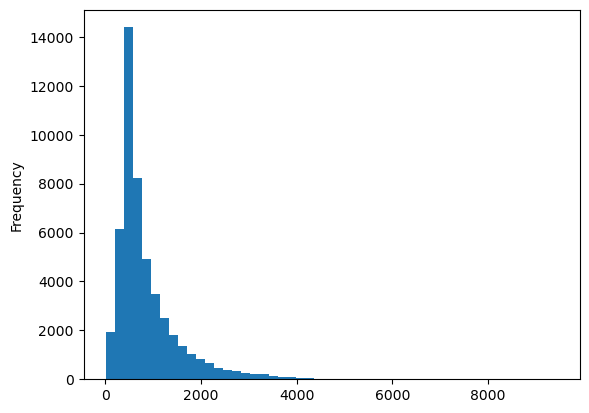

In [ ]:
# NOTE: 텍스트 데이터 전처리
# 모델의 input을 효율적으로하고 정확한 성능을 내기 위해서 텍스트데이터를 일관된 형식으로 변환하는 과정이 필요함.
# 1. 텍스트 정규화 -> "특수문자", "대/소문자", "두 칸 이상의 공백" 제거 
# 2. 자연어 처리에서 큰 의미를 가지지 않는다고 알려져 있는 불용어(stopword) 제거 
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

import re
def clean_text(text):
    text = text.lower() # 소문자화
    text = re.sub(r"<.*?>", "", text) # HTML태그 제거 
    text = re.sub(r"[^.a-z\s!?']", "", text) # 특수 문자 및 숫자 제거
    text = " ".join(word for word in text.split() if word not in stop_words) # 불용어 제거
    text = re.sub(r'([!?\'"])\1+', r'\1', text) # !?'이 2개 이상이면 한 개로 만들어줌.
    text = re.sub(r'\s+', ' ', text).strip() # 불필요한 공백 제거
    return text
IMDB['review_cleaned'] = IMDB['review'].apply(clean_text)
pd.Series([len(review) for review in IMDB["review_cleaned"].to_list()]).plot.hist(bins=50)

In [ ]:
# Load Module,Date for Tokenize&Embedding
# https://bo-10000.tistory.com/132
# https://huggingface.co/docs/tokenizers/api/tokenizer
from modules.util import save_pkl
from transformers import BertTokenizer
# BertTokenizer는 WordPiece로 토큰화 후에 임베딩함.(Subword-based tokenizer)
# REF: https://huggingface.co/docs/transformers/en/tokenizer_summary

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
tokenizer

/home/trifull/.conda/envs/sentLSTM/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


BertTokenizer(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
IMDB.head()
# 0, 101, 102, 103 = PAD, START, END, MASK
# 우리가 관심가지는건 0,101,102

# 0 = 형태의 일관성을 유지시켜주는 허래허식의 값.
# because, 각각의 문장의 길이가 현실 세계에서는 일정치 않아서, 지능이 떨어지는 컴퓨터는 다루기 힘들어서, 맞추어주는 작업을 해준다.
# e.g. token_length가 234, 127 이런 식의 벡터라면, padding작업을 거친 후 512,512의 같은 크기의 벡터로 변환해준다.

# 101,102 = 문장의 시작과 끝은 알려주는 토큰
# Because, 문장부호로도 알 수도 있지만,
# 하나의 512짜리 벡터안에서 끝맺음 문장부호(.)가 여러개 이면, 이 지능딸린 컴퓨터는 어 시발 어디지? 하기 때문.

,review,sentiment,review_cleaned
0,One of the other reviewers has mentioned that ...,1,one reviewers mentioned watching oz episode ho...
1,A wonderful little production. <br /><br />The...,1,wonderful little production. filming technique...
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,basically there's family little boy jake think...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter mattei's love time money visually stunn...


In [ ]:
# 단어집(vocab.) = 각각의 단어를 겹치지지않게 숫자로 매겨놓은 것
# input_ids 안에 있는 결과 = 문장 안의 단어를 단어집을 보고 숫자들의 조합으로 바꾸어준 것.
IMDB["review_token"] =  tokenizer(IMDB["review_cleaned"].to_list(),add_special_tokens=False)["input_ids"]
IMDB.head()

Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors
/tmp/ipykernel_3499983/2337951903.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IMDB["review_token"] =  tokenizer(IMDB["review_cleaned"].to_list(),add_special_tokens=False)["input_ids"]


,review,sentiment,review_cleaned,review_token
0,One of the other reviewers has mentioned that ...,1,one reviewers mentioned watching oz episode ho...,"[1141, 19475, 3025, 2903, 24919, 2004, 14111, ..."
1,A wonderful little production. <br /><br />The...,1,wonderful little production. filming technique...,"[7310, 1376, 1707, 119, 7973, 5531, 8362, 1119..."
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...,"[1354, 7310, 1236, 4511, 1159, 2633, 2247, 513..."
3,Basically there's a family where a little boy ...,0,basically there's family little boy jake think...,"[11519, 1175, 112, 188, 1266, 1376, 2298, 179,..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter mattei's love time money visually stunn...,"[11109, 2083, 22591, 1566, 1182, 112, 188, 156..."


/tmp/ipykernel_3499983/1651477978.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IMDB["token_length"] = IMDB["review_token"].apply(len)


(<Axes: ylabel='Frequency'>, 2188)

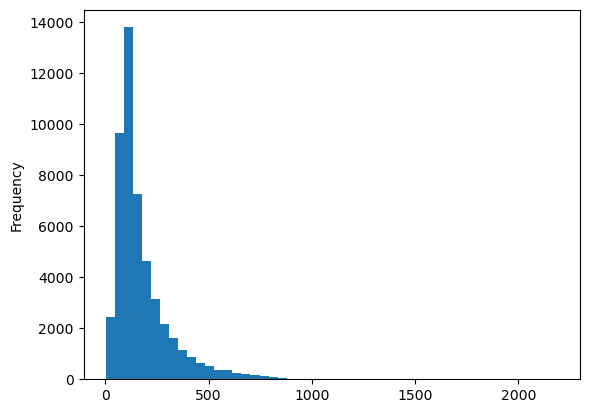

In [ ]:
IMDB["token_length"] = IMDB["review_token"].apply(len)
IMDB["token_length"].plot.hist(bins=50), max(IMDB["token_length"])

In [ ]:
# 토큰화한 것 중 512짜리가 넘는 건 지워버림
IMDB_512 = IMDB[IMDB["token_length"] <= 512]

# 데이터 셋의 변경이 있으니 확인하기.
# 적절한 Sample Size and Ratio 인가를 확인하기! -> 그렇다 적절타
print(sample_info := IMDB_512["sentiment"].value_counts().to_dict())
negative_num, postive_num = sample_info.values()

{0: 23905, 1: 23840}


In [ ]:
# Padding 해줌
IMDB_512["padded_token"] = IMDB_512["review_token"].apply(lambda _X: _X[:-1] + [0] * (512 - len(_X[:-1])))

/tmp/ipykernel_3499983/4265674423.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IMDB_512["padded_token"] = IMDB_512["review_token"].apply(lambda _X: _X[:-1] + [0] * (512 - len(_X[:-1])))


---

In [ ]:
# from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import random_split

torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Param
LEARNING_RATE = 0.001
N_EPOCHS = 25
BATCH_SIZE = 256

VOCAB_SIZE = tokenizer.vocab_size
EMBED_SIZE = 128
HIDDEN_SIZE = 64
HIDDEN_LAYER_DEPTH = 1
OUTPUT_DIM = 1

In [ ]:
IMDB_trainset = IMDB_512[["padded_token","sentiment"]]
x_train = torch.tensor(IMDB_trainset["padded_token"].to_list(),dtype=torch.int32)
y_train = torch.tensor(IMDB_trainset["sentiment"].to_list(),dtype=torch.float32).unsqueeze(1)

total_sample_size, content_length = x_train.shape
total_sample_size, content_length

(47745, 512)

In [ ]:
# 미니배치 단위로 Loss Backprop을 하기 위해 DataLoader 설정하기.
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# x_train[0]
# model(x_train[0:3].to(device)), x_train[0:3].to(device)
em = nn.Embedding(tokenizer.vocab_size,128).to(device)
em(x_train[0:3].to(device)).shape

torch.Size([3, 512, 128])

In [ ]:
# # https://wikidocs.net/64703
# class SentimentAnalysisRNN(nn.Module):
#     def __init__(
#         self,
#         input_dim=tokenizer.vocab_size,
#         output_dim=1,
#         embedding_dim=128,
#         hidden_dim=512,
#         layer_depth=1,
#         device=device
#     ) -> None:
#         super(SentimentAnalysisRNN, self).__init__()
#         # Var
#         self.layer_depth = layer_depth
#         self.hidden_dim = hidden_dim

#         # RNN
#         self.embed = nn.Embedding(input_dim, embedding_dim)
#         self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=layer_depth, batch_first=True)

#         # Decoder
#         self.class_decoder = nn.Sequential(
#             nn.Linear(hidden_dim, 64), nn.ReLU(), nn.Linear(64, output_dim), nn.Sigmoid()
#         )

#     def forward(self, x):
#         batch_size = x.size(0)

#         x = self.embed(x)
#         h_0 = torch.zeros(self.layer_depth, batch_size, self.hidden_dim).to(device)
#         x, _ = self.rnn(x, h_0)
        
#         x = x[:, -1, :]
#         x = self.class_decoder(x)
#         return x


# model = SentimentAnalysisRNN().to(device)

# # Binary Cross Entropy Loass
# loss_fn = nn.BCELoss().to(device)
# # ADAM Optimizer
# optimizer = optim.Adam(model.parameters(), LEARNING_RATE)
# # model

In [132]:
class SentimentAnalysisRNN(nn.Module):
    def __init__(
        self,
        vocab_dim=VOCAB_SIZE,
        embedding_dim=EMBED_SIZE,
        hidden_dim=HIDDEN_SIZE,
        layer_depth=HIDDEN_LAYER_DEPTH,
        output_dim=OUTPUT_DIM,
        device=device,
    ) -> None:
        super(SentimentAnalysisRNN, self).__init__()

        self.embed = nn.Embedding(vocab_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=layer_depth, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()  # 시그모이드 활성화 함수 추가

        self.hidden_dim = hidden_dim
        self.layer_depth = layer_depth
        self.device = device

    def forward(self, x):
        embed = self.embed(x)
        y_t_list, h_t_list = self.rnn(embed)
        y_t = y_t_list[:, -1, :]
        out = self.fc(y_t)  # 마지막 RNN 출력을 사용
        return out


# Training setup
model = SentimentAnalysisRNN(tokenizer.vocab_size, device=device).to(device)
loss_fn = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [135]:
# print(x_train[0:2].shape)

# em = nn.Embedding(VOCAB_SIZE,EMBED_SIZE)
# print(em(x_train[0:2]).shape)

# rnn = nn.RNN(EMBED_SIZE,HIDDEN_SIZE)
# y_ls, h_ls = rnn(em(x_train[0:2]))
# print(y_ls.shape, h_ls.shape)
# print(y_ls[:,-1,:].shape)
# # HIDDEN_SIZE
# linear =  nn.Linear(HIDDEN_SIZE, 1)
# linear(y_ls[:,-1,:])

# sigmoid = nn.Sigmoid()
# sigmoid(linear(y_ls[:,-1,:]))

In [ ]:
loss_obs = []
for i in tqdm(range(100)):
    for batch_idx, samples in enumerate(dataloader):
        x_batch,y_batch = samples
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        predicted = model(x_batch)
        
        loss = loss_fn(predicted,y_batch.float())
        loss.backward()
        optimizer.step()
        
        if batch_idx%15==0:
            print(loss,predicted,y_batch)
            break
        

    break

  0%|          | 0/100 [00:00<?, ?it/s]/opt/conda/conda-bld/pytorch_1729647350383/work/aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [0,0,0], thread: [32,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1729647350383/work/aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [0,0,0], thread: [33,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1729647350383/work/aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [0,0,0], thread: [34,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1729647350383/work/aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [0,0,0], thread: [35,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1729647350383/work/aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [0,0,0], thread: [36,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


: 

In [ ]:
pd.Series(loss_obs).plot.line()

In [ ]:
with torch.no_grad():
    print(model(x_train[:100]))

y_train[:100]